In [4]:
# импорты 
import pandas as pd
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [5]:
# путь к исходному файлу с результатами теста
path_to_file = './data/split_form.xlsx'

In [6]:
# чтение файла в датафрейм
split = pd.read_excel(path_to_file)

split.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_os_version,config_resolution,idvisit,platform_v4
10170,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,8,360x720,5896887,MOB
23640,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,8.1,360x640,4737109,MOB
20579,Other,Other,SMARTPHONE,0,new,AND,7,320x570,5380818,MOB


In [7]:
# список измерений для группировки и вычислений
diminsion_col = ['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_os_version', 'config_resolution', 'platform_v4']

In [8]:
# No action required: Leave the original dataframe untouched and sort the new dataframe
split2 = split.copy()

In [9]:
# считаем кол-во визитов в разрезе необходимых измерений
split2['visit_cnt'] = split2.groupby(diminsion_col)['idvisit'].transform('count')


split2 = split2.astype({"visit_cnt": int}, errors='ignore')

split2 = split2.filter(['DEVICES_BRANDS', 'BROWSERS', 'DEVICE_TYPE', 'Conversion'
                 , 'A/B', 'config_os', 'config_resolution', 'config_os_version', 'platform_v4', 'visit_cnt'])

split2.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_resolution,config_os_version,platform_v4,visit_cnt
15404,SAMSUNG,CHROME MOBILE,SMARTPHONE,0,new,AND,360x640,8,MOB,119.0
18866,Other,CHROME MOBILE,SMARTPHONE,0,new,AND,360x640,6,MOB,1200.0
320,HUAWEI,Other,SMARTPHONE,1,old,AND,360x640,6,MOB,1.0


In [10]:
# из-за отсутствия id_user сделаю проверку по идентификатору визита
session_counts = split['idvisit'].value_counts(ascending=False)
multi_visit = session_counts[session_counts > 1].count()

print(f'There are {multi_visit} users that appear multiple times in the dataset')

# окей с отсутствием дублей

There are 0 users that appear multiple times in the dataset


## Sampling

In [90]:
# random_state=22 для воспроизводимости результатов
control_sample = split2[split2['A/B'] == 'old'].sample(n=10000, random_state=22)
test_sample = split2[split2['A/B'] == 'new'].sample(n=10000, random_state=22)

ab_test = pd.concat([control_sample, test_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.sample(3)

,DEVICES_BRANDS,BROWSERS,DEVICE_TYPE,Conversion,A/B,config_os,config_resolution,config_os_version,platform_v4,visit_cnt
7731,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,360x640,7,MOB,1701.0
8941,Other,CHROME MOBILE,SMARTPHONE,0,old,AND,360x720,8.1,MOB,529.0
2221,Other,CHROME,TABLET,0,old,AND,960x600,4.4,WEB,2.0


In [91]:
conversion_rates = ab_test.groupby(['A/B'])['Conversion']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
A/B,,,
new,0.122,0.327,0.003
old,0.122,0.327,0.003


Text(0, 0.5, 'Converted (proportion)')

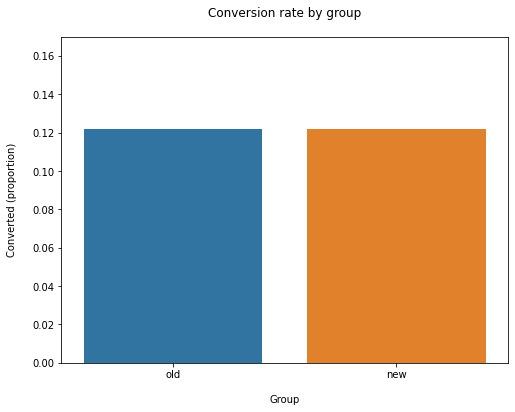

In [92]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['A/B'], y=ab_test['Conversion'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

### Странно, что макро конверсия не изменяется. Есть ли смысл копаться в микроконверсиях, чтобы иметь доп.информацию по важности?
### P.S. аналогичные результаты выдавал полностью есь датасет без сэмплирования.

In [14]:
# List of names of unique names of the segments
brows_list = list(split2['BROWSERS'].unique())
dev_br_list = list(split2['DEVICES_BRANDS'].unique())
dev_type_list = list(split2['DEVICE_TYPE'].unique())
platf_list = list(split2['platform_v4'].unique())

In [15]:
# Count of the number of segments (or total test variations)
variations_brows = len(brows_list)
variations_dev_brand = len(dev_br_list)
variations_dev_type = len(dev_type_list)
variations_platf = len(platf_list)

# Verify that the segments/categories are correct 
print('Different brow: ',brows_list, 'Number of segments: ', variations_brows)
print('Different dev brand: ',dev_br_list, 'Number of segments: ', variations_dev_brand)
print('Different device type: ',dev_type_list, 'Number of segments: ', variations_dev_type)
print('Different version platform: ',platf_list, 'Number of segments: ', variations_platf)

Different brow:  ['CHROME MOBILE', 'Other', 'MOBILE SAFARI', 'CHROME', 'FIREFOX'] Number of segments:  5
Different dev brand:  ['Other', 'SAMSUNG', 'APPLE', 'HUAWEI'] Number of segments:  4
Different device type:  ['SMARTPHONE', nan, 'PHABLET', 'DESKTOP', 'TABLET', 'PORTABLE_MEDIA_PAYER'] Number of segments:  6
Different version platform:  ['MOB', 'WEB'] Number of segments:  2


# Конверсия по типу платформы (Conversions Per Platform)

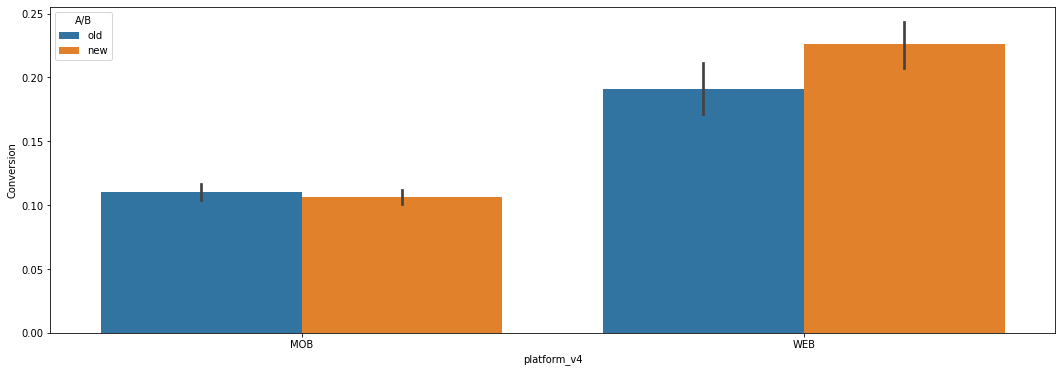

In [17]:
# platform_v4

fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='platform_v4'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

### По новой форме конверсия на WEB (порядка 22% в тестовой группе) показивает рост, в отличии от МОВ. Необходимо рассмотреть более детально срезы по этой платформе.

<AxesSubplot:ylabel='visit_cnt'>

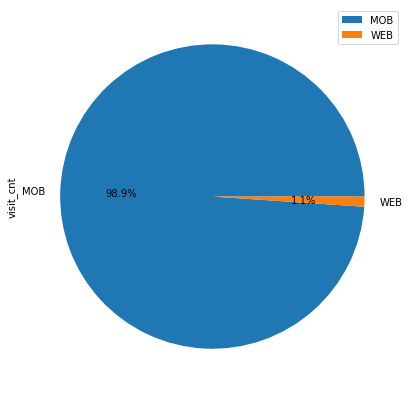

In [18]:
split2.groupby(['platform_v4']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(18,7)
                                             , autopct='%1.1f%%')

### Этот сегмент в структуре занимает почти весь трафик - рассмотрим детально нет ли багов. 

# **Конверсия по типу девайса (Conversions Per Device)**

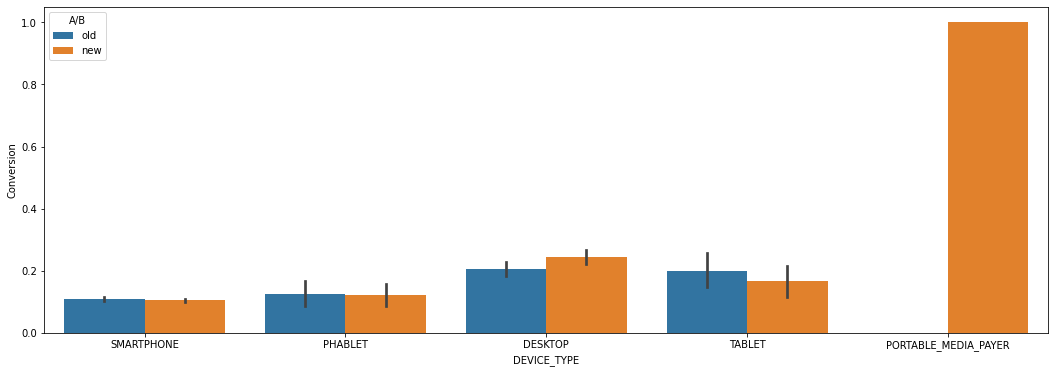

In [19]:
# DEVICE_TYPE в целом
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

## Идет просадка на смартфонах и фаблетах (гибрид телефона+планшета), важно понять какую долю они занимают в структуре трафика? поскольку практически 90% (нижняя визуализация), то необходимо понять, что внутри не так...

<AxesSubplot:ylabel='visit_cnt'>

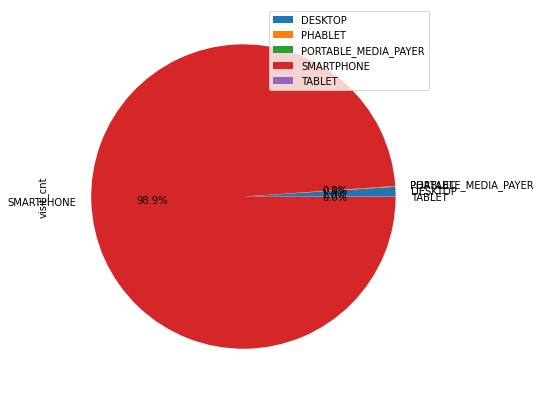

In [20]:
split2.groupby(['DEVICE_TYPE']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(18,7)
                                             , autopct='%1.1f%%')

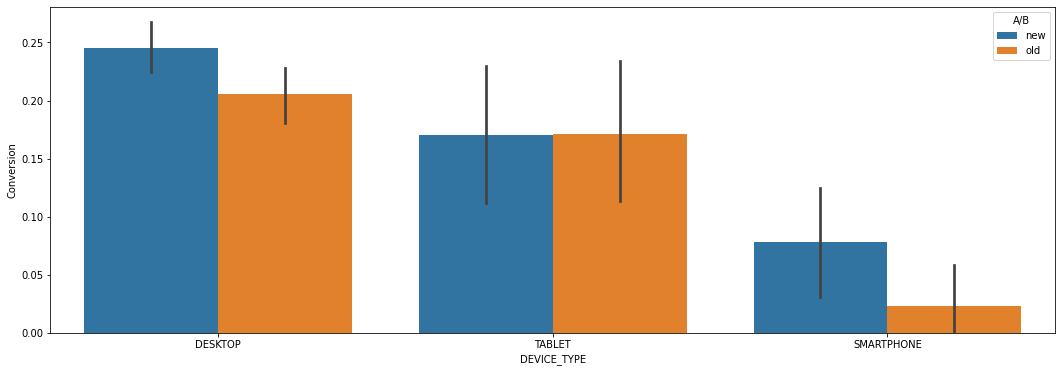

In [21]:
# DEVICE_TYPE на вебе 
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='WEB'], ax=ax)
plt.show()

### такс... ????? что-то тут не согласовуется с верхним по росту на вебе

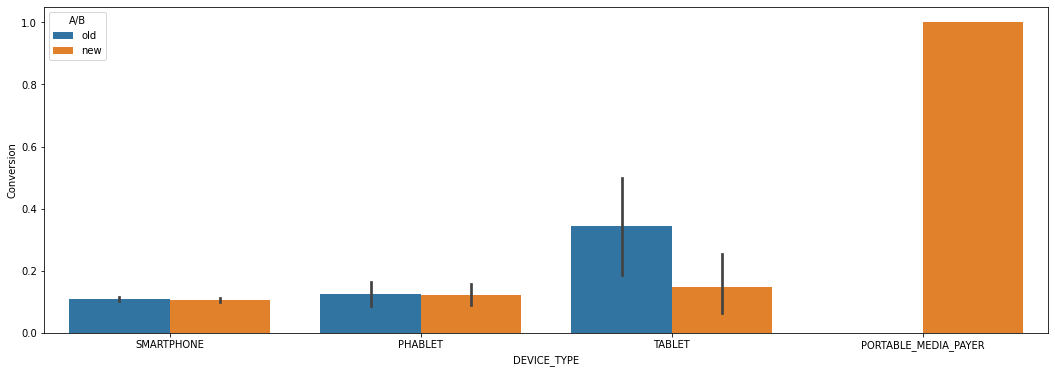

In [22]:
# DEVICE_TYPE на моб
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICE_TYPE'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='MOB'], ax=ax)
plt.show()

# **Конверсия по типу операционной системы**

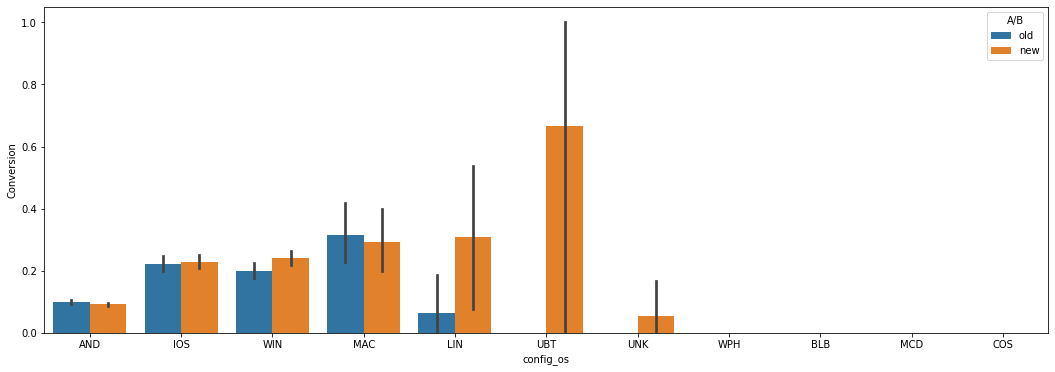

In [23]:
# config_os
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_os'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

## Коэффициент конверсии на iOS разнится от коэффициента на Android, в последнего идёт понижение. Возможно, при разработке что-то не учтено. И если брать во внимание трафик (нижний график) с Android, то понижение - плохо, т.к. он занимает всю структуру.

<AxesSubplot:ylabel='visit_cnt'>

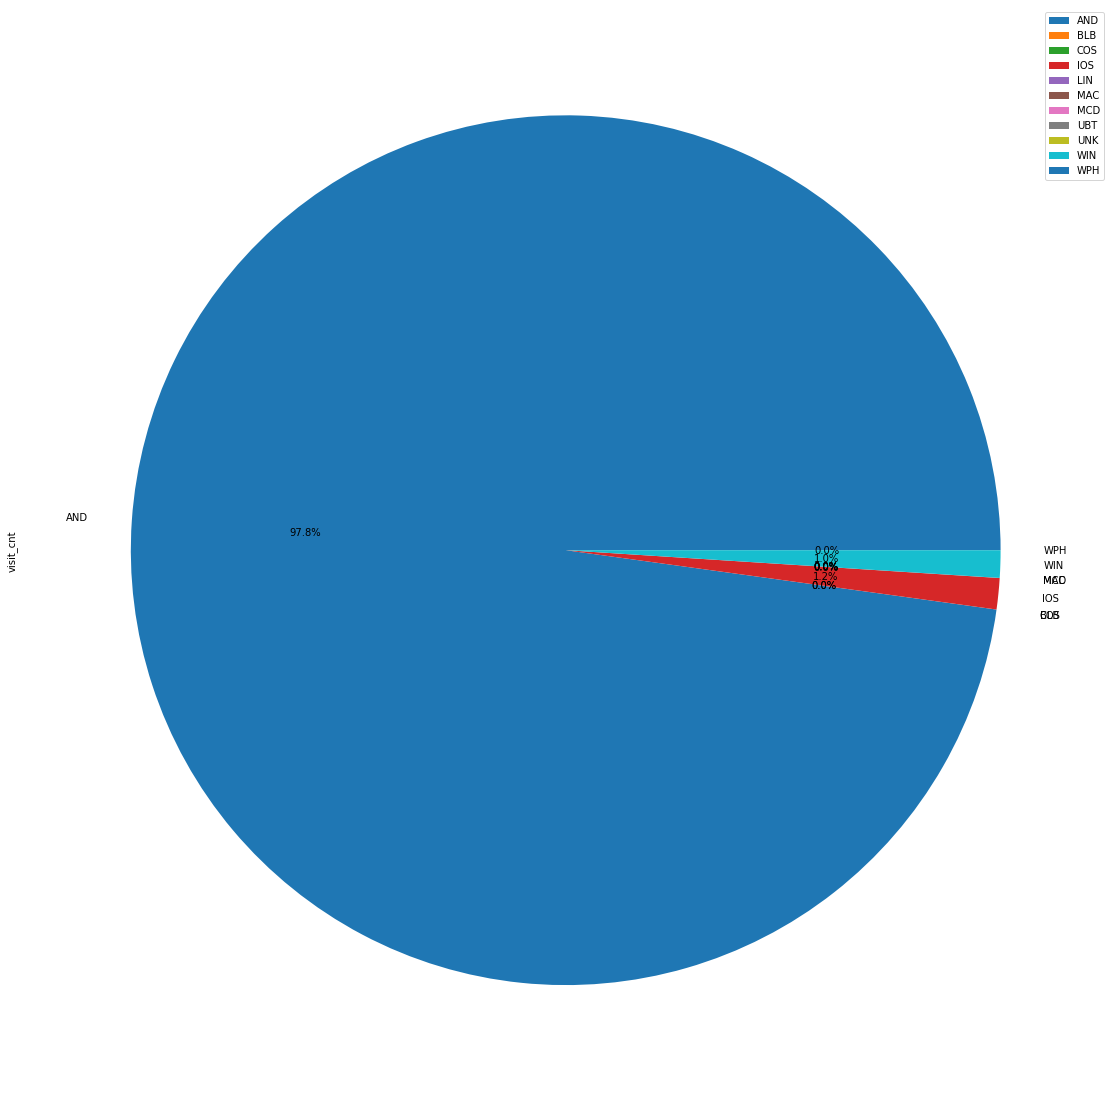

In [24]:
split2.groupby(['config_os']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,20)
                                             , autopct='%1.1f%%')

## Пойдем глянем в марку Android-девайсов

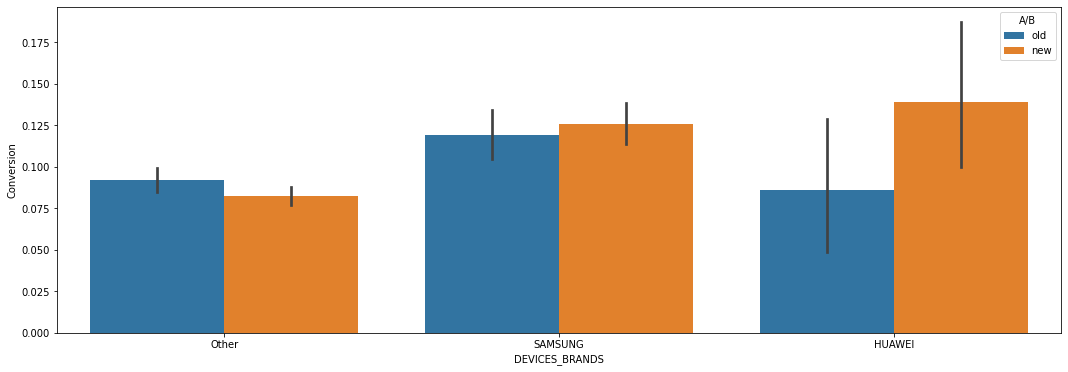

In [25]:
# DEVICES_BRANDS
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='DEVICES_BRANDS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.config_os=='AND'], ax=ax)
plt.show()

<AxesSubplot:ylabel='visit_cnt'>

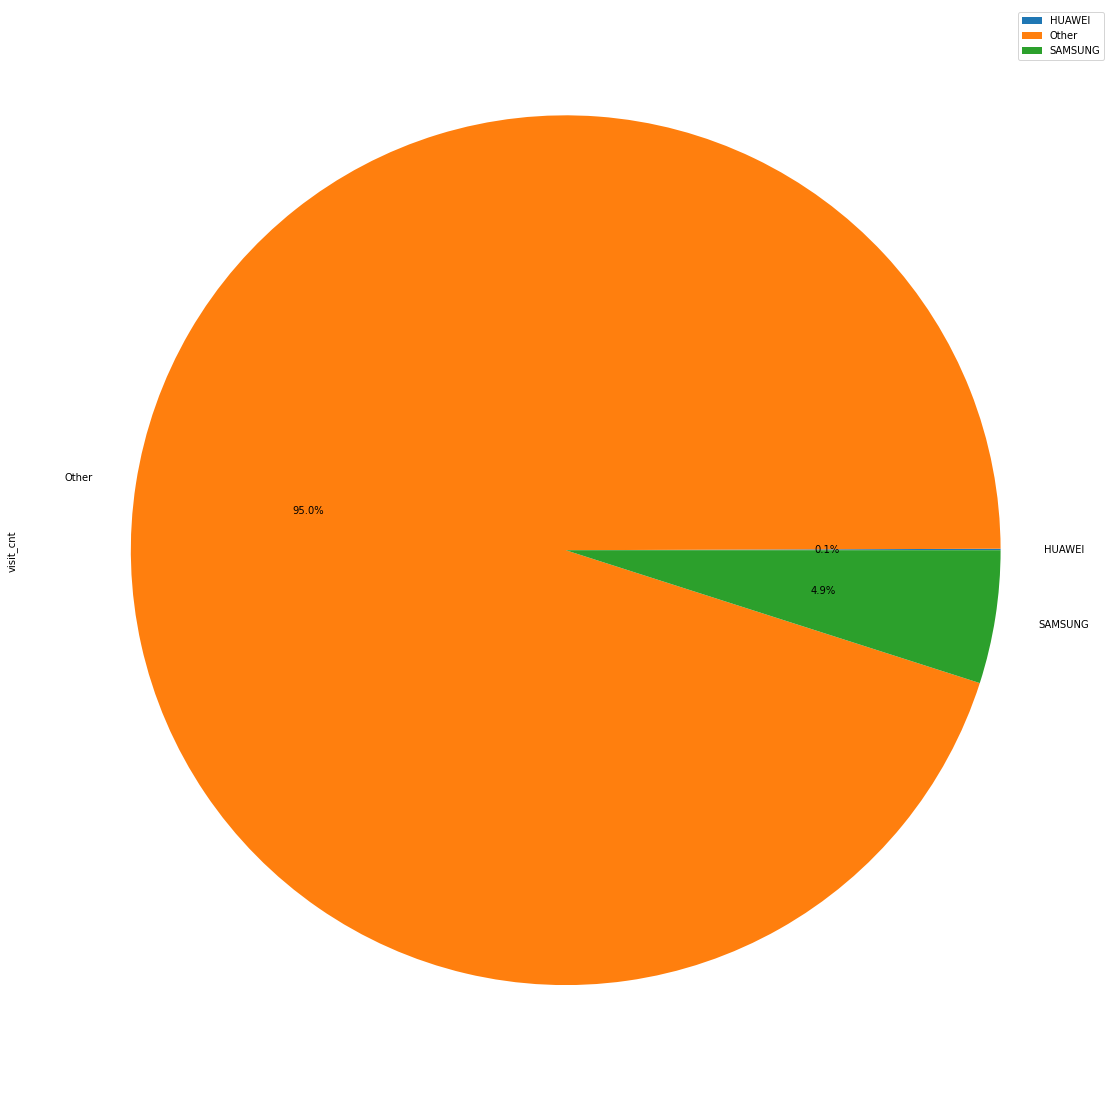

In [26]:
split2[split2.config_os=='AND'].groupby(['DEVICES_BRANDS']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,20)
                                             , autopct='%1.1f%%')

## Предполагаю, что нюанс может быть с конфигами

In [86]:
data=split2[(split2.config_os=='AND')&(split2.DEVICES_BRANDS=='Other')]

by_resol = (data
            .groupby('A/B')
            .filter(lambda x : len(x) > 500)
            .groupby(['config_resolution', 'A/B'])['Conversion']
            .agg([np.mean])
            .unstack()
           ).fillna(-99)

pd.set_option('display.max_rows', by_resol.shape[0]+1)
by_resol

mean           
A/B                      new        old
config_resolution                      
1006x754            0.000000 -99.000000
1024x552            0.000000   0.000000
1024x600            0.333333   0.000000
1067x600            0.000000 -99.000000
1080x1920           0.333333   0.500000
1081x2162           0.000000 -99.000000
1280x752            0.000000 -99.000000
1280x800            0.000000   0.000000
1368x768          -99.000000   0.000000
1440x1440         -99.000000   1.000000
1440x900            0.000000 -99.000000
1680x1050           0.333333   0.000000
1920x1080         -99.000000   0.000000
218x189           -99.000000   0.000000
282x348             0.000000 -99.000000
300x392             0.000000   0.000000
300x405           -99.000000   0.000000
300x425             0.000000   0.000000
300x432           -99.000000   0.000000
320x480             0.000000   0.000000
320x496           -99.000000   0.000000
320x522             0.000000   0.000000
320x533             0.000000 -99.000000
320x534             0.047414   0.053030
320x569             0.103448   0.034483
320x570             0.055705   0.058902
320x640             0.044643   0.042553
333x665           -99.000000   0.000000
337x471           -99.000000   0.000000
337x557             0.000000 -99.000000
342x442             0.000000 -99.000000
342x454             0.000000   0.000000
342x455           -99.000000   0.000000
342x487           -99.000000   0.000000
342x500             0.333333 -99.000000
346x692             0.000000   0.000000
347x617           -99.000000   0.000000
351x623           -99.000000   1.000000
356x633           -99.000000   0.000000
360x525           -99.000000   1.000000
360x592             0.169811   0.095238
360x594             0.000000   0.000000
360x595           -99.000000   0.000000
360x596             0.000000 -99.000000
360x598             0.000000   0.000000
360x600             0.000000   0.666667
360x601             0.000000   0.000000
360x603             0.000000   0.000000
360x605           -99.000000   0.000000
360x640             0.087523   0.096845
360x668             0.285714   1.000000
360x672             0.437500   0.785714
360x678           -99.000000   0.000000
360x720             0.084894   0.098952
360x750             0.135135   0.142857
360x760             0.222222   0.000000
360x780             1.000000 -99.000000
361x642             0.000000   0.000000
372x661             0.000000 -99.000000
376x564             0.000000 -99.000000
376x668             0.000000 -99.000000
376x752             0.000000   0.000000
377x628             0.250000   0.000000
377x670             0.000000   0.090909
377x753             0.142857   0.000000
381x676             0.333333 -99.000000
381x677             0.000000 -99.000000
384x512             0.500000   0.000000
393x699             0.043956   0.105263
393x786             0.000000   0.166667
393x830             0.000000 -99.000000
396x664             0.500000   0.000000
400x584           -99.000000   0.000000
400x712             0.000000   0.000000
400x800             0.000000 -99.000000
408x725             0.000000 -99.000000
410x728             0.000000 -99.000000
412x618             0.176471   0.000000
412x732             0.115108   0.121495
412x823             0.111111   0.187500
412x869             0.250000 -99.000000
414x736           -99.000000   0.000000
414x803             0.000000 -99.000000
421x748             0.000000   0.000000
424x753             0.034884   0.094340
424x848             0.076923   0.277778
424x895             0.000000   0.000000
427x760             0.000000 -99.000000
432x768             0.000000   0.000000
432x864             0.000000 -99.000000
438x854           -99.000000   0.000000
439x586             0.000000 -99.000000
444x788             0.000000 -99.000000
450x900             0.000000   0.000000
451x770             0.040000   0.023256
455x809             0.500000 -99.000000
455x960           -99.000000   0.333333
458x915             0.00

In [88]:
by_vers = (data
            .groupby('A/B')
            .filter(lambda x : len(x) > 500)
            .groupby(['config_os_version', 'A/B'])['Conversion']
            .agg([np.mean])
            .unstack()
           ).fillna(-99)

pd.set_option('display.max_rows', by_vers.shape[0]+1)
by_vers

mean           
A/B                     new        old
config_os_version                     
4.0                0.500000   0.000000
4.1                0.250000 -99.000000
4.2                0.000000   0.333333
4.3                0.500000   0.250000
4.4                0.068120   0.056250
5.0                0.088889   0.102273
5.1                0.071775   0.071233
6.0                0.068409   0.087973
6.1                0.071429   0.153846
7.0                0.088999   0.099025
7.1                0.082645   0.118919
8.0                0.101648   0.152778
8.1                0.086130   0.081716

# Конверсия по браузерам (Conversions Per Browser)

<AxesSubplot:ylabel='visit_cnt'>

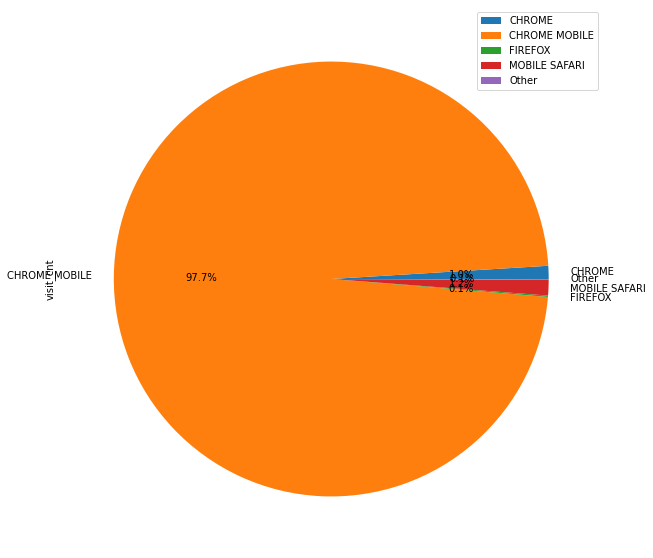

In [40]:
split2.groupby(['BROWSERS']).sum().plot(kind='pie'
                                              , y='visit_cnt'
                                              , figsize=(20,10)
                                             , autopct='%1.1f%%')

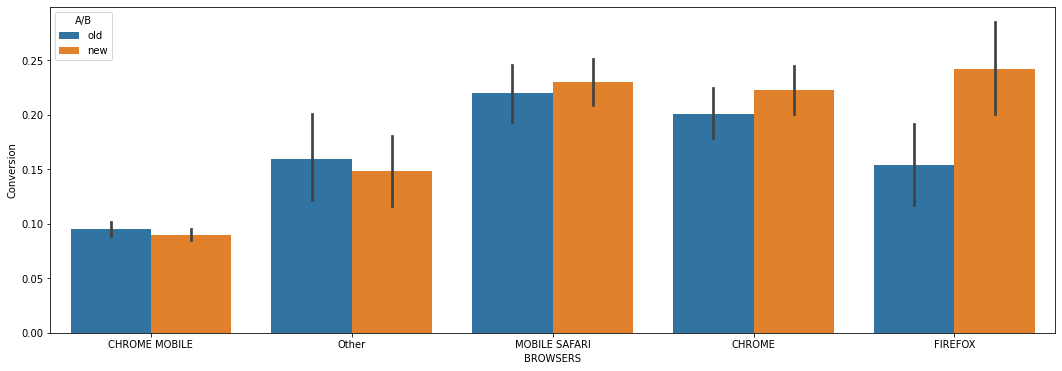

In [41]:
# BROWSERS
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2, ax=ax)
plt.show()

### Потестить, что не так с Chrome mobile и Другие в тестовой группе. Возможно что-то с отобрабражением формы. Т.к. на других - ок.

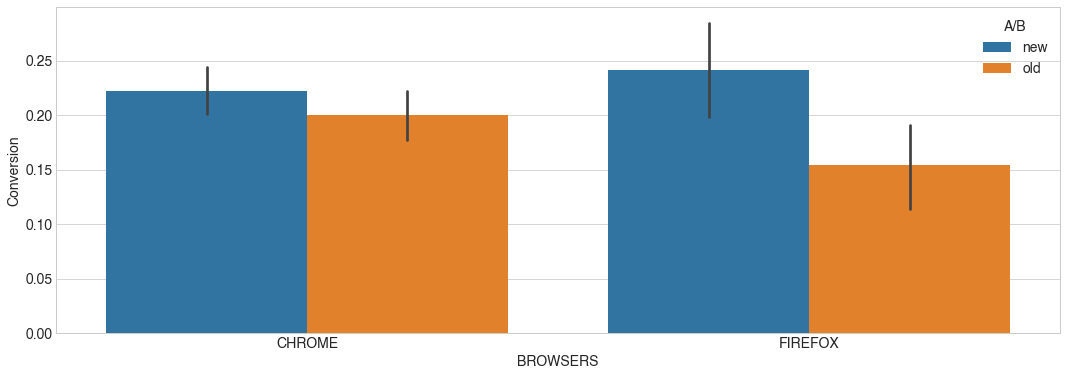

In [261]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='WEB'], ax=ax)
plt.show()

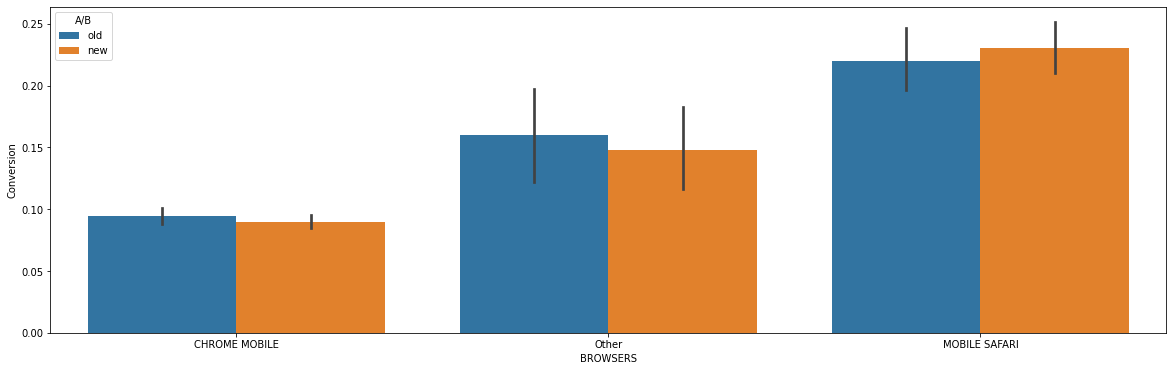

In [42]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x='BROWSERS'
            , y='Conversion'
            , hue='A/B'
            , data=split2[split2.platform_v4=='MOB'], ax=ax)
plt.show()

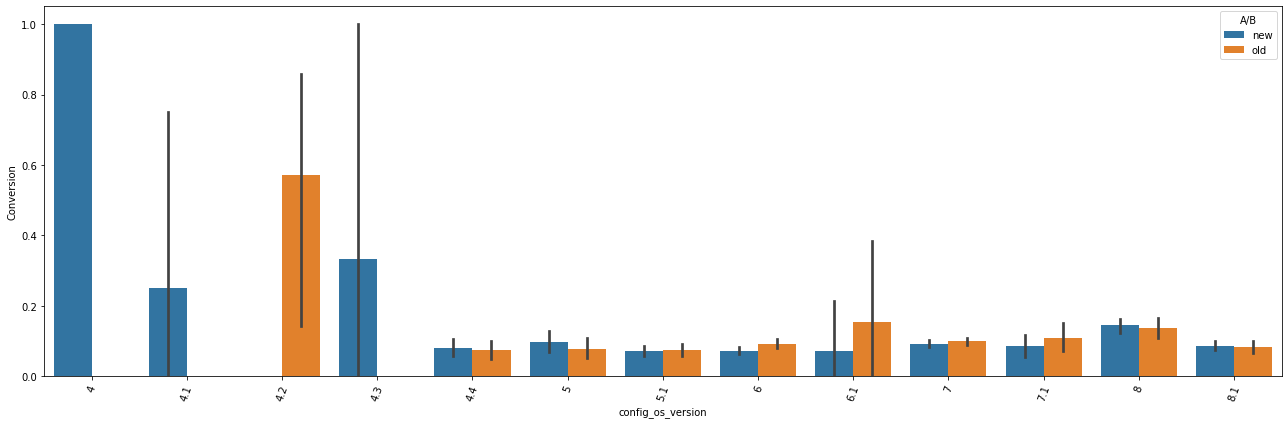

In [81]:
# BROWSERS ON mobile
fig, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x='config_os_version'
            , y='Conversion'
            , hue='A/B'
            , data=split2[(split2.BROWSERS=='CHROME MOBILE')
                         &(split2.config_os=='AND')].sort_values(by=['config_os_version', 'A/B']
                                                               , ascending=True)
            # [split2.BROWSERS=='CHROME MOBILE']
            #, data=split2[split2.BROWSERS=='CHROME MOBILE']
            , ax=ax)

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

Хорошо бы понимать сегменты трафика с каких версий опер.с-мы - даст понимание с чем работать и соответственно на конверсию какой ОС обратить внимание.

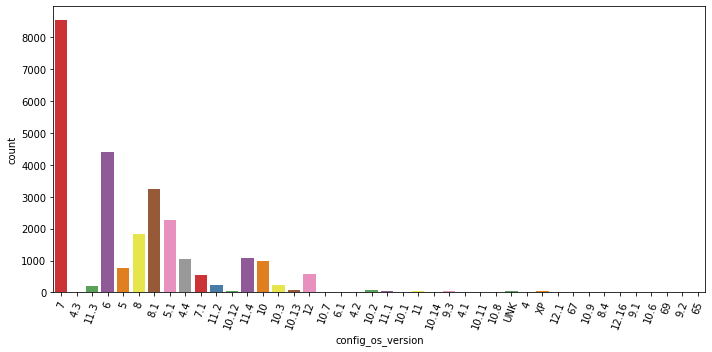

In [83]:
plt.figure(figsize=(10,5))
chart = sns.countplot(
    data=split2,
    x='config_os_version',
    palette='Set1'
)

plt.xticks(rotation=70)
plt.tight_layout()

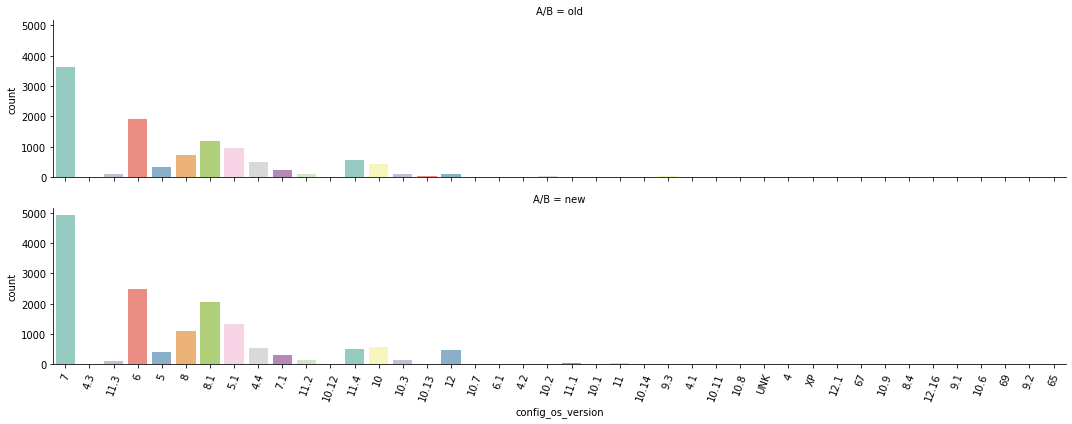

In [84]:
chart = sns.catplot(
    data=split2[split2['A/B'].isin(['new', 'old'])],
    x='config_os_version',
    kind='count',
    palette='Set3',
    row='A/B',
    aspect=5,
    height=3
)
plt.xticks(rotation=70)
plt.tight_layout()

опять видим, что распределение ос не одинаково в группах.